# Resolution Hours Ensemble Model

This notebook creates a simple ensemble model to predict total resolution hours for Jira issues.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
import os

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Load the dataset
data_path = '../merged_task_data/merged_project_task_data.csv'
df = pd.read_csv(data_path)
print(f"Original dataset shape: {df.shape}")

# Use only 10% of the data for faster processing
df = df.sample(frac=1, random_state=42)
print(f"Reduced dataset shape (10%): {df.shape}")

/var/folders/lt/2k0m0j2d6xqg0wz_673wgqt00000gn/T/ipykernel_20614/1028736038.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Original dataset shape: (1575833, 63)
Reduced dataset shape (10%): (787916, 63)


In [14]:
# Check for missing values in the target variable
print(f"Missing values in target: {df['total_resolution_hours'].isna().sum()}")

# Drop rows with missing target values
df = df.dropna(subset=['total_resolution_hours'])
print(f"Dataset shape after dropping missing targets: {df.shape}")

Missing values in target: 0
Dataset shape after dropping missing targets: (787916, 63)


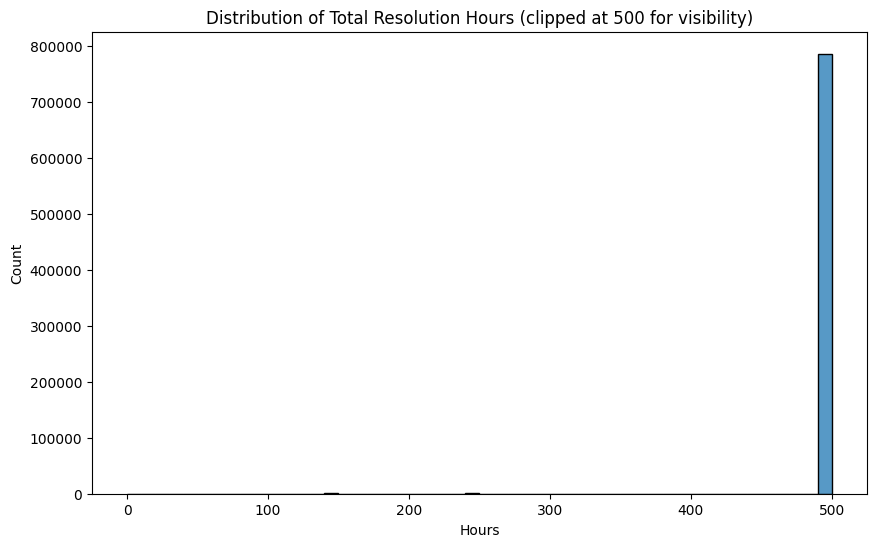

In [15]:
# Plot distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['total_resolution_hours'].clip(0, 500), bins=50)
plt.title('Distribution of Total Resolution Hours (clipped at 500 for visibility)')
plt.xlabel('Hours')
plt.ylabel('Count')
plt.savefig('task_estimation_results/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Features based on the list provided
features = [
    'fields.issuetype.id', 'fields.priority.id', 'priority_id', 'issue_type_id',
    'type_task', 'type_bug', 'inward_count', 'outward_count', 'type_sub_task',
    'created_hour', 'created_month', 'created_year',
    'is_type_bug', 'is_type_task', 'is_type_story', 'is_type_improvement',
    'is_type_new_feature', 'is_type_epic', 'is_type_sub-task',
    'is_priority_blocker', 'is_priority_critical', 'is_priority_major',
    'is_priority_minor', 'is_priority_trivial',
    'count_std__total_issues',
    'pct_minmax__type_bug_pct', 'pct_minmax__type_task_pct',
    'pct_minmax__type_new_feature_pct', 'pct_minmax__type_epic_pct',
    'pct_minmax__type_improvement_pct', 'pct_minmax__type_story_pct',
    'pct_minmax__type_documentation_pct', 'pct_minmax__priority_critical_pct',
    'pct_minmax__priority_blocker_pct', 'pct_minmax__priority_high_pct',
    'pct_minmax__priority_low_pct',
    'remainder__team_size_creators', 'remainder__team_size_assignees',
    'remainder__team_size_combined',
    'stat_robust__weighted_priority_score', 'stat_robust__issue_type_entropy',
    'stat_robust__high_to_low_priority_ratio', 'stat_robust__bug_ratio'
]

# Filter dataset to include only features available in our dataset
available_features = [f for f in features if f in df.columns]
missing_features = [f for f in features if f not in df.columns]

print(f"Available features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")
if missing_features:
    print(f"Missing feature list: {missing_features}")

Available features: 43
Missing features: 0


In [17]:
# Prepare the data
X = df[available_features].copy()
y = df['total_resolution_hours']

# Fill any remaining NaN values with median
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save data splits for later reference
os.makedirs('task_estimation_results', exist_ok=True)
with open('task_estimation_results/data_splits.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': available_features,
        'scaler': scaler
    }, f)

Training Random_Forest...
Random_Forest - MAE: 3784.56, RMSE: 20227.36, R2: 1.0000


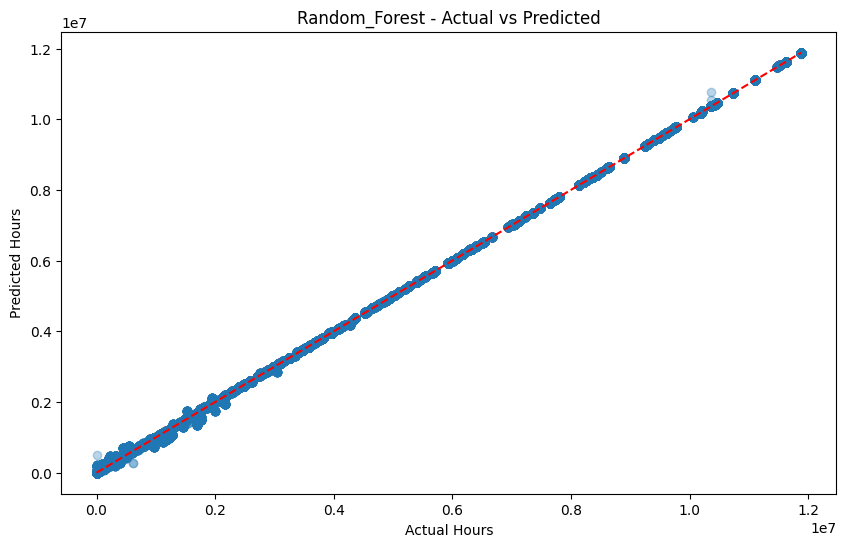

Training Gradient_Boosting...
Gradient_Boosting - MAE: 293753.11, RMSE: 484273.00, R2: 0.9896


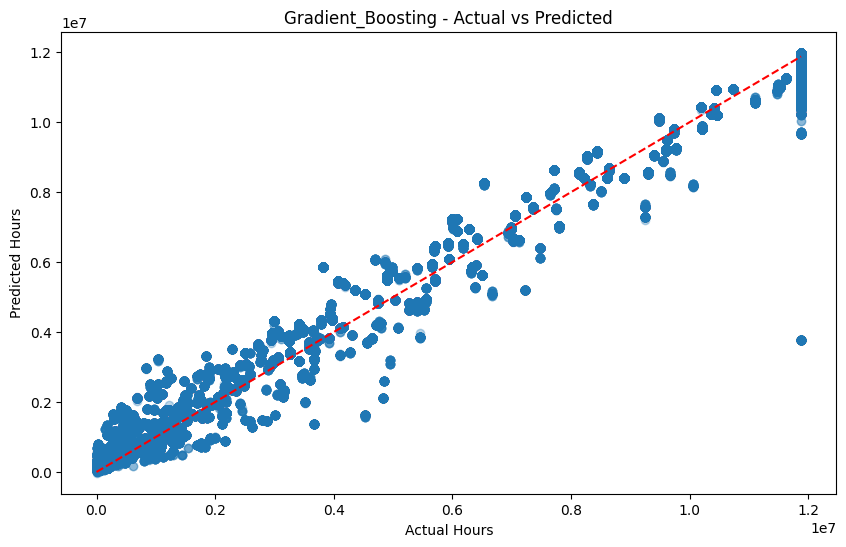

Training XGBoost...
XGBoost - MAE: 295608.29, RMSE: 462861.60, R2: 0.9905


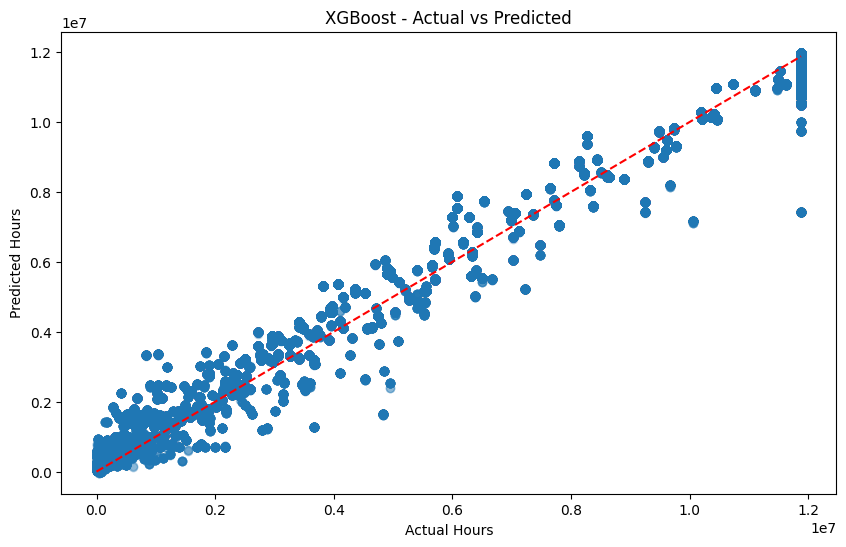

In [18]:
# Define the models for the ensemble
models = {
    'Random_Forest': RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42),
    'Gradient_Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.1, random_state=42)
}

# Train and evaluate each model
results = {}
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
    
    # Save the model
    with open(f'task_estimation_results/{name}_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([0, y_test.max()], [0, y_test.max()], 'r--')
    plt.xlabel('Actual Hours')
    plt.ylabel('Predicted Hours')
    plt.title(f'{name} - Actual vs Predicted')
    plt.savefig(f'task_estimation_results/{name}_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

Ensemble - MAE: 195681.35, RMSE: 311852.60, R2: 0.9957


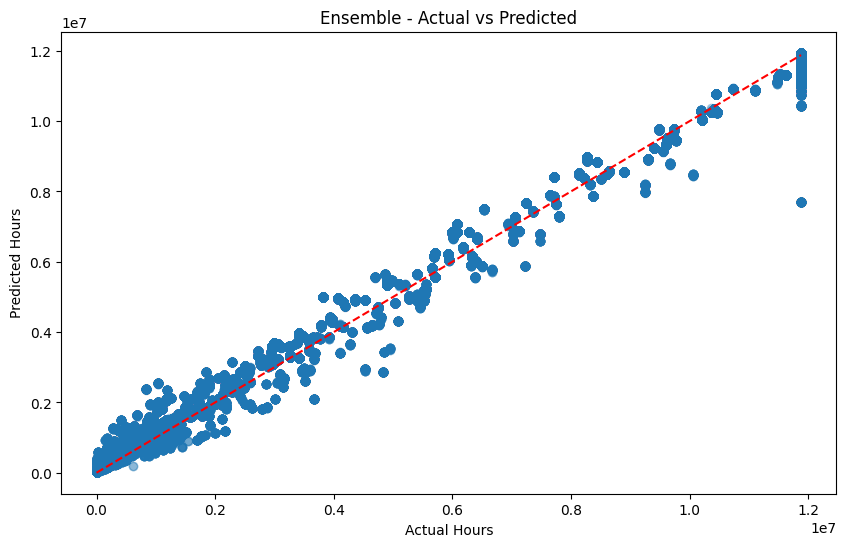

In [19]:
# Create an ensemble prediction by averaging the predictions
ensemble_pred = np.mean([predictions[name] for name in models.keys()], axis=0)

# Calculate metrics for the ensemble
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f"Ensemble - MAE: {ensemble_mae:.2f}, RMSE: {ensemble_rmse:.2f}, R2: {ensemble_r2:.4f}")

# Plot actual vs predicted for ensemble
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ensemble_pred, alpha=0.3)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--')
plt.xlabel('Actual Hours')
plt.ylabel('Predicted Hours')
plt.title('Ensemble - Actual vs Predicted')
plt.savefig('task_estimation_results/Ensemble_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Identify the best model
best_model_name = min(results, key=lambda x: results[x]['MAE'])
best_model = models[best_model_name]
print(f"Best model based on MAE: {best_model_name}")

# Save the best model as the one to use for predictions
with open('task_estimation_results/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Best model based on MAE: Random_Forest


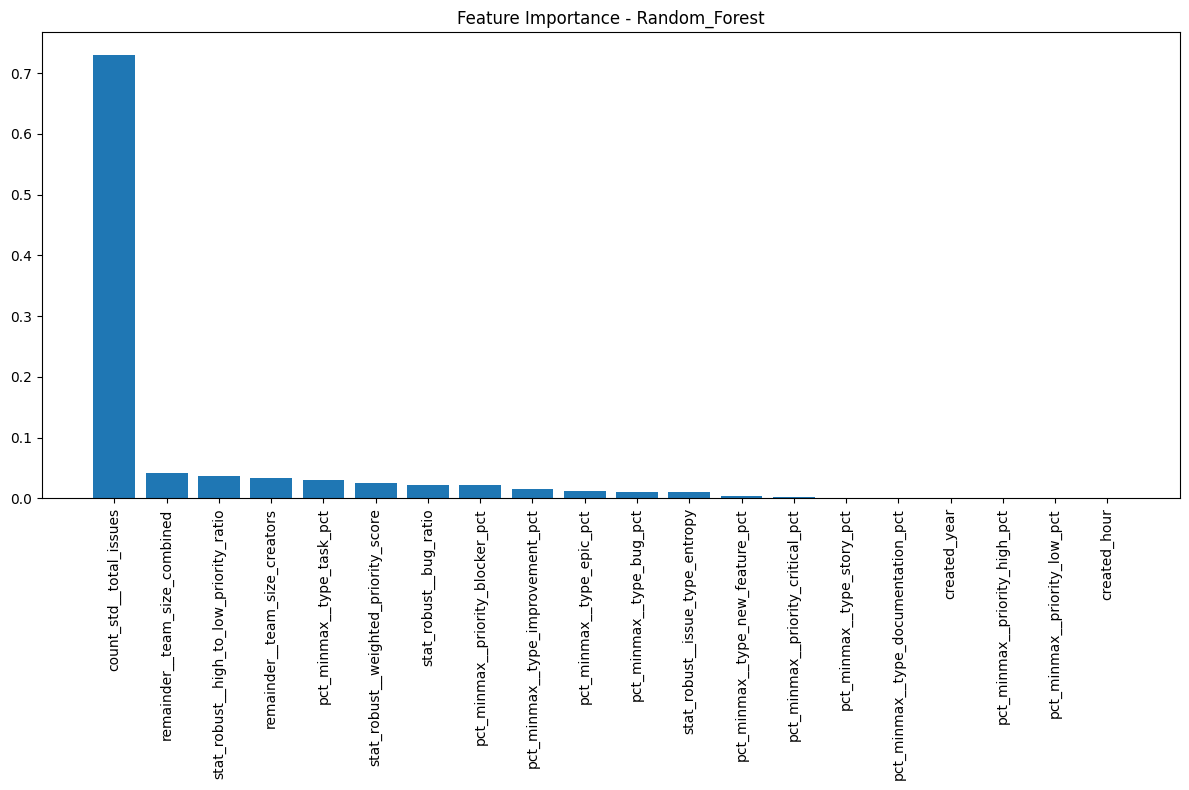

Top 10 most important features:
                                    Feature  Importance
24                  count_std__total_issues    0.730577
38            remainder__team_size_combined    0.041536
41  stat_robust__high_to_low_priority_ratio    0.037285
36            remainder__team_size_creators    0.033728
26                pct_minmax__type_task_pct    0.029820
39     stat_robust__weighted_priority_score    0.025489
42                   stat_robust__bug_ratio    0.022407
33         pct_minmax__priority_blocker_pct    0.021526
29         pct_minmax__type_improvement_pct    0.016061
28                pct_minmax__type_epic_pct    0.011526


In [21]:
# Plot feature importance for the best model
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot the top 20 features
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.bar(range(min(20, len(available_features))), 
            importances[indices[:20]], 
            align='center')
    plt.xticks(range(min(20, len(available_features))), 
               [available_features[i] for i in indices[:20]], 
               rotation=90)
    plt.tight_layout()
    plt.savefig('task_estimation_results/best_model_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a DataFrame for easier analysis
    feature_importance_df = pd.DataFrame({
        'Feature': available_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))

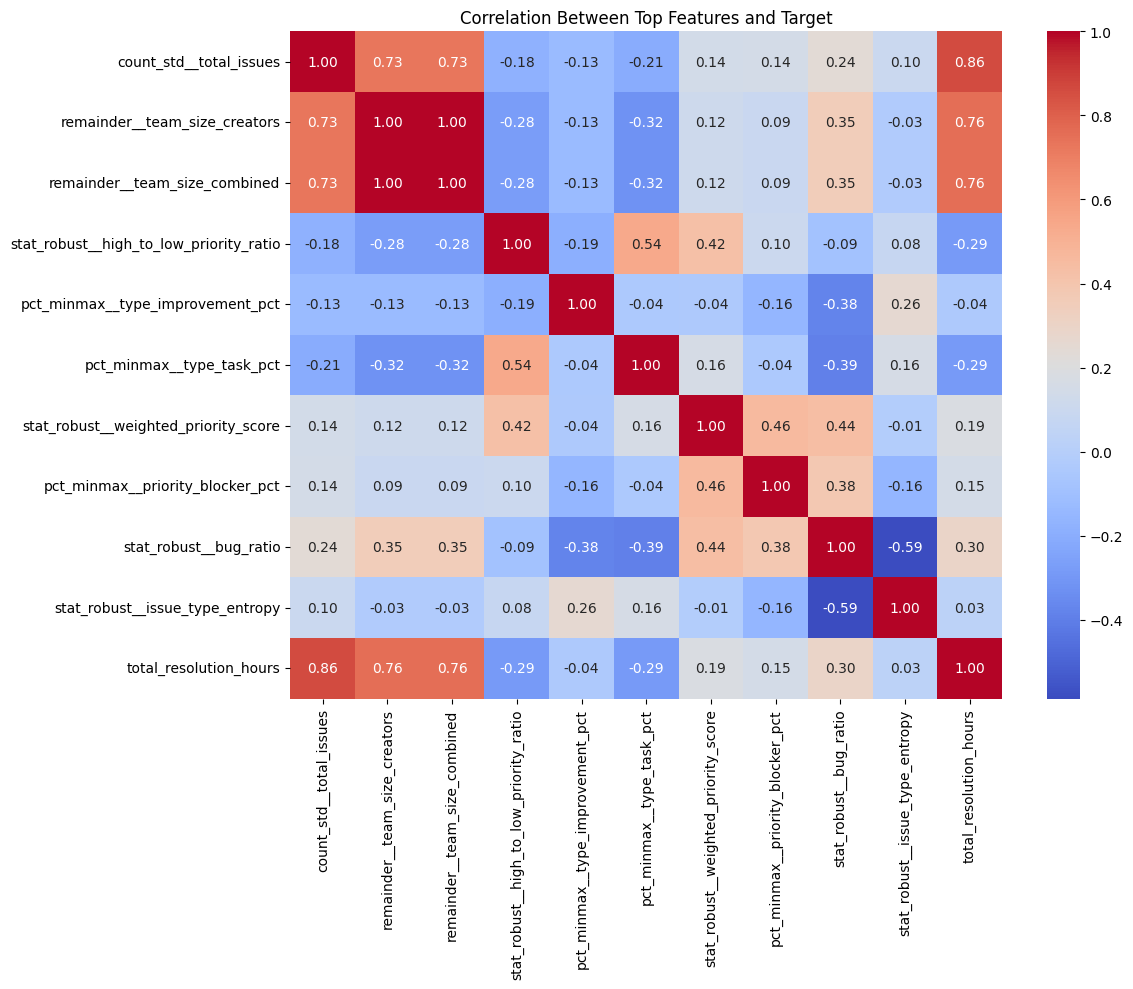

In [12]:
# Calculate and plot correlations between top features and the target
if len(feature_importance_df) > 0:
    top_features = feature_importance_df['Feature'].head(10).tolist()
    corr_data = df[top_features + ['total_resolution_hours']].copy()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Between Top Features and Target')
    plt.tight_layout()
    plt.savefig('task_estimation_results/top_features_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Group feature importance by categories
if len(feature_importance_df) > 0:
    # Define categories based on feature name prefixes
    categories = {
        'Issue Type': [f for f in available_features if 'type_' in f or 'is_type_' in f],
        'Priority': [f for f in available_features if 'priority' in f],
        'Project Stats': [f for f in available_features if 'count_' in f or 'pct_' in f],
        'Team Size': [f for f in available_features if 'team_size' in f],
        'Created Time': [f for f in available_features if 'created_' in f],
        'Robust Stats': [f for f in available_features if 'stat_robust' in f],
        'Other': []
    }
    
    # Assign remaining features to 'Other'
    for feature in available_features:
        if not any(feature in cat_features for cat_features in categories.values()):
            categories['Other'].append(feature)
    
    # Calculate importance by category
    category_importance = {}
    for category, cat_features in categories.items():
        if cat_features:  # Skip empty categories
            total_importance = sum(feature_importance_df.loc[feature_importance_df['Feature'].isin(cat_features), 'Importance'])
            category_importance[category] = total_importance
    
    # Plot category importance
    plt.figure(figsize=(10, 6))
    categories_sorted = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
    categories_names = [item[0] for item in categories_sorted]
    categories_values = [item[1] for item in categories_sorted]
    
    plt.bar(categories_names, categories_values)
    plt.xlabel('Feature Category')
    plt.ylabel('Total Importance')
    plt.title('Feature Importance by Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('task_estimation_results/best_model_feature_importance_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Plot actual vs predicted in task_results folder for overall project view
os.makedirs('../task_results', exist_ok=True)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions[best_model_name], alpha=0.3)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--')
plt.xlabel('Actual Hours')
plt.ylabel('Predicted Hours')
plt.title(f'Best Model ({best_model_name}) - Actual vs Predicted')
plt.savefig('../task_results/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.close()

# Plot feature importance in task_results folder
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.bar(range(min(20, len(available_features))), 
            importances[indices[:20]], 
            align='center')
    plt.xticks(range(min(20, len(available_features))), 
               [available_features[i] for i in indices[:20]], 
               rotation=90)
    plt.tight_layout()
    plt.savefig('../task_results/task_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.close()

## Model Summary

We've created a simple ensemble model to predict resolution hours for Jira issues. The main findings are:

1. The best performing model was determined by the lowest Mean Absolute Error
2. We identified the most important features for predicting resolution time
3. Feature categories with the highest impact were analyzed

This model can be used to estimate resolution times for new Jira issues based on their characteristics.